<a href="https://colab.research.google.com/github/shubha07m/vision-language-modeling/blob/main/experiment_with_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing required libraries
import torch
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import io
import os
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# setting up google drive
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/sample_images/special_type'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model1 = models.mobilenet_v3_small(weights='IMAGENET1K_V1')

In [ ]:
# Function for creating image embedding model
def get_image_embedder(model):
    # Remove the last classification layer
    layers = list(model.children())[:-1]

    # Define the embedder model
    embed_model = nn.Sequential(*layers)

    # Set model to evaluation mode
    embed_model.eval()

    return embed_model

In [ ]:
# Function to extract the embedding for a single image

def get_embedding(image_path, model):
    # Define the transformation inside this function
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    image = Image.open(image_path)
    transformed_image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        embedding = model(transformed_image)
    return embedding.numpy()

In [ ]:
# function to detect dissimilar frames

def images_to_embeddings(folder_path, model, top_n_frames=3, total_frames=168, subframes=21):
    embed_model = get_image_embedder(model)
    frames = sorted(os.listdir(folder_path))[:total_frames]  # Restrict to the first `total_frames`
    group_frames = []  # To store image paths grouped with base and dissimilar frames

    # Process frames in chunks of `subframes`
    for i in range(0, len(frames), subframes):
        chunk_frames = frames[i:i + subframes]  # Get `subframes` frames
        embeddings_list = []
        frame_paths = []

        for image_file in chunk_frames:
            image_path = os.path.join(folder_path, image_file)
            if os.path.isfile(image_path) and image_file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp')):
                embedding = get_embedding(image_path, embed_model)
                # Flatten embedding to 2D before similarity comparison
                flattened_embedding = embedding.flatten().reshape(1, -1)
                embeddings_list.append(flattened_embedding)
                frame_paths.append(image_path)  # Keep track of the image path

        # Base frame (first in the chunk)
        base_embedding = embeddings_list[0]

        # Compute cosine similarity between the base and the rest of the frames
        similarities = []
        for j in range(1, len(embeddings_list)):
            similarity = cosine_similarity(base_embedding, embeddings_list[j])[0][0]
            similarities.append(similarity)

        # Get indices of the top `top_n_frames` most dissimilar frames (lowest similarity)
        top_n_indices = np.argsort(similarities)[:top_n_frames]  # n lowest similarities

        # Create a group of frames with base + top dissimilar frames
        group = [frame_paths[0]]  # Add base frame
        for idx in top_n_indices:
            group.append(frame_paths[idx + 1])  # Add top dissimilar frames

        group_frames.append(group)  # Store the group for later display

    return group_frames  # Return grouped image paths

In [ ]:
# Function to display frames in group
def display_frame_groups(grouped_paths):
    """Displays frames in groups with base and top dissimilar frames."""
    fig, axs = plt.subplots(len(grouped_paths), len(grouped_paths[0]), figsize=(15, 5 * len(grouped_paths)))

    for row_idx, group in enumerate(grouped_paths):
        for col_idx, frame_path in enumerate(group):
            image = Image.open(frame_path)
            axs[row_idx, col_idx].imshow(image)
            axs[row_idx, col_idx].axis('off')  # Hide axis

    plt.show()

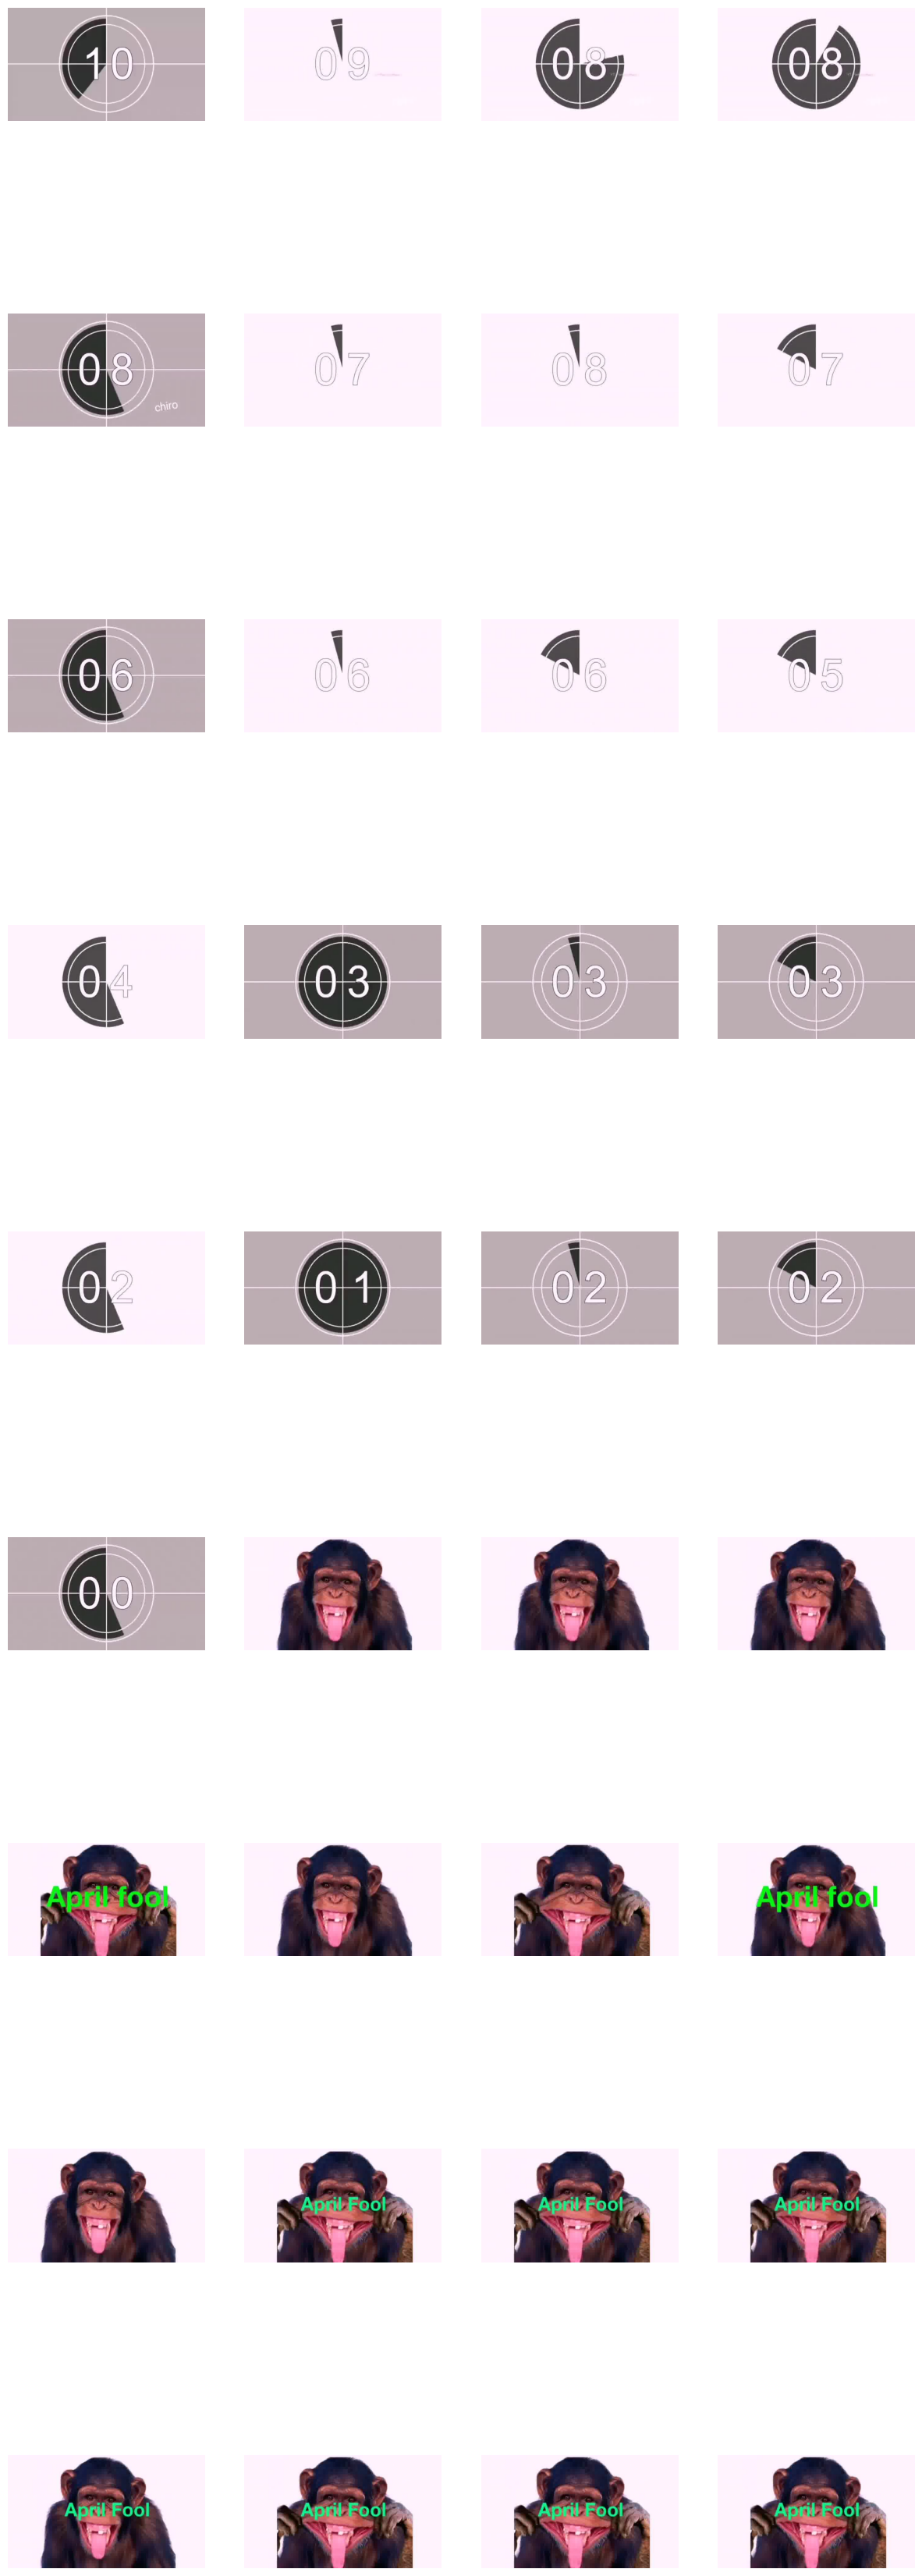

In [ ]:
# Display frames
grouped_frames = images_to_embeddings(dataset_path, model=model1, top_n_frames=3, total_frames=170, subframes=20)
display_frame_groups(grouped_frames)

In [ ]:
print(test.shape)

(24, 1, 576)
